Entry GDX: 46.65
Entry GLD: 185.16
Exit GDX: 41.39
Exit GLD: 188.82
PnL GDX: 5262.04
PnL GLD: 5866.00
Total PnL: 11128.04


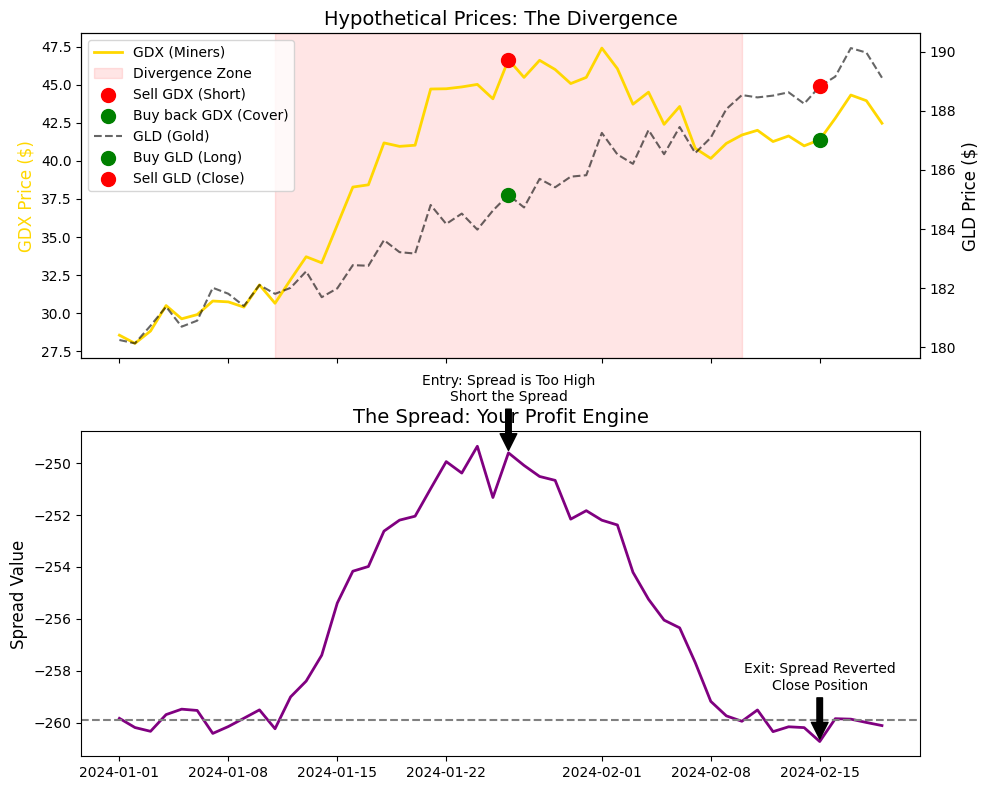

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Setup Hypothetical Data
np.random.seed(42)
days = 50
date_range = pd.date_range(start='2024-01-01', periods=days)

# Define Hedge Ratio
hedge_ratio = 1.6

# Generate GLD (Gold) price - steady slight uptrend + noise
gld_prices = np.linspace(180, 190, days) + np.random.normal(0, 0.5, days)

# Generate GDX (Miners) price
# Ideally it should follow GLD * hedge_ratio, but we introduce a "Divergence Event"
# Days 15-35: GDX rallies irrationally (The "Bubble")
noise = np.random.normal(0, 0.5, days)
divergence = np.zeros(days)
# Create a hump (divergence)
divergence[10:40] = np.sin(np.linspace(0, np.pi, 30)) * 10 

gdx_prices = (gld_prices * hedge_ratio) + divergence + noise - 260 # -260 is just an arbitrary intercept to make prices look realistic (e.g. ~$30)

# 2. Calculate Spread
# Spread = Y - beta * X
# We usually center it or include intercept, but for raw trading logic:
spread = gdx_prices - (hedge_ratio * gld_prices)

# 3. Define Trade Points
# Entry: Day 25 (Peak of divergence)
entry_day = 25
entry_gld = gld_prices[entry_day]
entry_gdx = gdx_prices[entry_day]
entry_spread = spread[entry_day]

# Exit: Day 45 (Convergence)
exit_day = 45
exit_gld = gld_prices[exit_day]
exit_gdx = gdx_prices[exit_day]
exit_spread = spread[exit_day]

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top Plot: Prices
ax1.plot(date_range, gdx_prices, label='GDX (Miners)', color='gold', linewidth=2)
# To make them comparable on one chart, we often plot scaled versions, but let's just plot secondary axis or just raw prices if they fit. 
# GDX is ~30, GLD is ~180. Better to use dual axis.
ax1_twin = ax1.twinx()
ax1_twin.plot(date_range, gld_prices, label='GLD (Gold)', color='black', linestyle='--', alpha=0.6)

ax1.set_ylabel('GDX Price ($)', color='gold', fontsize=12)
ax1_twin.set_ylabel('GLD Price ($)', color='black', fontsize=12)
ax1.set_title('Hypothetical Prices: The Divergence', fontsize=14)

# Highlight the divergence
ax1.axvspan(date_range[10], date_range[40], color='red', alpha=0.1, label='Divergence Zone')

# Markers for Trade
ax1.scatter(date_range[entry_day], entry_gdx, color='red', s=100, zorder=5, label='Sell GDX (Short)')
ax1_twin.scatter(date_range[entry_day], entry_gld, color='green', s=100, zorder=5, label='Buy GLD (Long)')

ax1.scatter(date_range[exit_day], exit_gdx, color='green', s=100, zorder=5, label='Buy back GDX (Cover)')
ax1_twin.scatter(date_range[exit_day], exit_gld, color='red', s=100, zorder=5, label='Sell GLD (Close)')

# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')


# Bottom Plot: The Spread
ax2.plot(date_range, spread, label='Spread (GDX - 1.6*GLD)', color='purple', linewidth=2)
ax2.axhline(spread[0:10].mean(), color='gray', linestyle='--', label='Mean Spread')
ax2.set_ylabel('Spread Value', fontsize=12)
ax2.set_title('The Spread: Your Profit Engine', fontsize=14)

# Annotate Trade
ax2.annotate('Entry: Spread is Too High\nShort the Spread', 
             xy=(date_range[entry_day], spread[entry_day]), 
             xytext=(date_range[entry_day], spread[entry_day]+2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center')

ax2.annotate('Exit: Spread Reverted\nClose Position', 
             xy=(date_range[exit_day], spread[exit_day]), 
             xytext=(date_range[exit_day], spread[exit_day]+2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center')

plt.tight_layout()
plt.savefig('pairs_trading_illustration.png')

# 5. Calculate PnL for Text Output
# Position Sizing: Short 1000 shares of GDX. Long HedgeRatio * 1000 shares of GLD? 
# Usually we dollar neutralize or hedge ratio quantity neutralize.
# Let's match the hedge ratio definition: 1 unit of Y, Beta units of X.
# Trade: Short 1000 GDX, Long (1000 * 1.6) GLD = 1600 GLD.

shares_gdx = 1000
shares_gld = shares_gdx * hedge_ratio # 1600

# Entry Cashflow
short_proceeds = shares_gdx * entry_gdx
long_cost = shares_gld * entry_gld

# Exit Cashflow
cover_cost = shares_gdx * exit_gdx
sell_proceeds = shares_gld * exit_gld

# PnL
pnl_gdx = short_proceeds - cover_cost # Profit if price went down
pnl_gld = sell_proceeds - long_cost   # Profit if price went up

total_pnl = pnl_gdx + pnl_gld

print(f"Entry GDX: {entry_gdx:.2f}")
print(f"Entry GLD: {entry_gld:.2f}")
print(f"Exit GDX: {exit_gdx:.2f}")
print(f"Exit GLD: {exit_gld:.2f}")
print(f"PnL GDX: {pnl_gdx:.2f}")
print(f"PnL GLD: {pnl_gld:.2f}")
print(f"Total PnL: {total_pnl:.2f}")